In [6]:
!pip install tensorflow keras seaborn matplotlib scikit-learn pandas opencv-python


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, shutil
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report


In [8]:
DATASET = "/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset"


In [9]:
import os, shutil, random

output_dir = "/content/fish_split_dataset"
train_dir = f"{output_dir}/train"
val_dir = f"{output_dir}/val"
test_dir = f"{output_dir}/test"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Assuming DATASET contains direct class folders, and each class folder contains 'images' and 'labels' subdirectories.
classes = os.listdir(DATASET)
# Filter out any items that are not directories from the main DATASET folder
classes = [c for c in classes if os.path.isdir(os.path.join(DATASET, c))]


for cls in classes:
    # Ensure the target directories for the split exist
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # The actual images are in a subdirectory named 'images' within each class folder
    source_image_dir = os.path.join(DATASET, cls, 'images')

    if not os.path.exists(source_image_dir):
        print(f"Warning: 'images' subdirectory not found in {os.path.join(DATASET, cls)}. Skipping this class.")
        continue

    all_items_in_images_dir = os.listdir(source_image_dir)
    # Filter to ensure only files (and not subdirectories if any exist within 'images') are considered
    all_imgs = [img_name for img_name in all_items_in_images_dir if os.path.isfile(os.path.join(source_image_dir, img_name))]

    if not all_imgs:
        print(f"No image files found in {source_image_dir}. Skipping this class.")
        continue

    random.shuffle(all_imgs)

    n = len(all_imgs)
    train_split = int(0.7 * n)
    val_split   = int(0.9 * n)

    for img_file in all_imgs[:train_split]:
        shutil.copy(os.path.join(source_image_dir, img_file), os.path.join(train_dir, cls, img_file))

    for img_file in all_imgs[train_split:val_split]:
        shutil.copy(os.path.join(source_image_dir, img_file), os.path.join(val_dir, cls, img_file))

    for img_file in all_imgs[val_split:]:
        shutil.copy(os.path.join(source_image_dir, img_file), os.path.join(test_dir, cls, img_file))

print("✅ Dataset split completed!")

✅ Dataset split completed!


In [10]:
img_size = 224
batch = 32

train_gen = ImageDataGenerator(rescale=1/255.0)
val_gen   = ImageDataGenerator(rescale=1/255.0)
test_gen  = ImageDataGenerator(rescale=1/255.0)

train_data = train_gen.flow_from_directory(train_dir, target_size=(img_size,img_size),
                                           class_mode='categorical', batch_size=batch)
val_data = val_gen.flow_from_directory(val_dir, target_size=(img_size,img_size),
                                       class_mode='categorical', batch_size=batch)
test_data = test_gen.flow_from_directory(test_dir, target_size=(img_size,img_size),
                                         class_mode='categorical', batch_size=batch)


Found 4535 images belonging to 6 classes.
Found 1296 images belonging to 6 classes.
Found 648 images belonging to 6 classes.


In [11]:
base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False   # freeze for lower accuracy

x = Flatten()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,854 (68.39 MB)

 Trainable params: 3,212,166 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.3035 - loss: 1.7356 - val_accuracy: 0.4877 - val_loss: 1.3552
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.5257 - loss: 1.2629 - val_accuracy: 0.6034 - val_loss: 1.1566
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.6409 - loss: 1.0386 - val_accuracy: 0.6644 - val_loss: 0.9979
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.7133 - loss: 0.8511 - val_accuracy: 0.6752 - val_loss: 0.9481
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.7719 - loss: 0.7287 - val_accuracy: 0.7215 - val_loss: 0.8417
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.8044 - loss: 0.6253 - val_accuracy: 0.7446 - val_loss: 0.7648
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.8522 - loss: 0.5332 - val_accuracy: 0.7593 - val_loss: 0.7271
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.8829 - loss: 0.4617 - val

In [13]:
df = pd.DataFrame(history.history)
csv_path = "/content/drive/MyDrive/vgg16_training_results.csv"
df.to_csv(csv_path, index=False)
print("📄 CSV saved:", csv_path)


📄 CSV saved: /content/drive/MyDrive/vgg16_training_results.csv


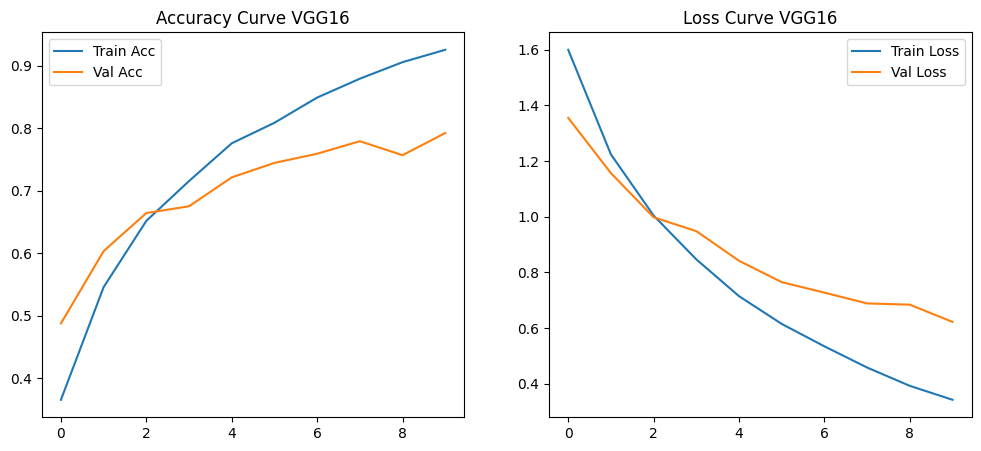

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy Curve VGG16")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve VGG16")
plt.legend()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step


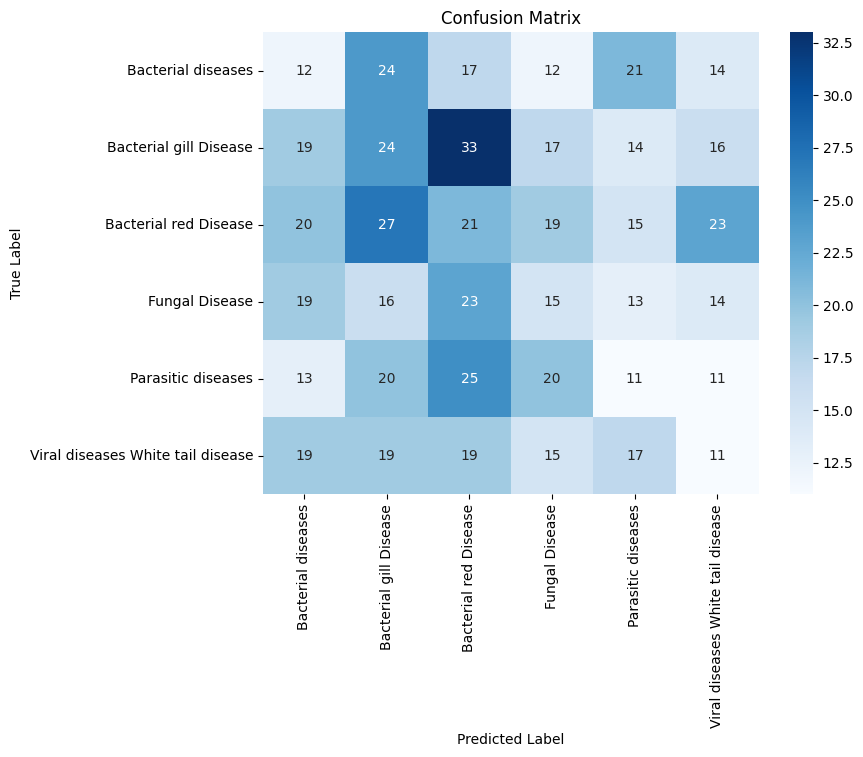

In [15]:
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [16]:
print(classification_report(y_true, y_pred, target_names=labels))


                                   precision    recall  f1-score   support

               Bacterial diseases       0.12      0.12      0.12       100
           Bacterial gill Disease       0.18      0.20      0.19       123
            Bacterial red Disease       0.15      0.17      0.16       125
                   Fungal Disease       0.15      0.15      0.15       100
               Parasitic diseases       0.12      0.11      0.12       100
Viral diseases White tail disease       0.12      0.11      0.12       100

                         accuracy                           0.15       648
                        macro avg       0.14      0.14      0.14       648
                     weighted avg       0.14      0.15      0.14       648

